In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

Import the total runoff qtot for the years 1971-2010 for hydrological model DBH forced by climate model GSWP3. Each file span over 10 years, with the following line I combine all of them in a single file. Also the values are scaled to be in mm/day and not kg / (m^2* s) by multiplying for 86400.

In [4]:
qdummy= xr.open_mfdataset("dbh_gswp3_nobc_hist_varsoc_co2_qtot_lat43.0to49.0lon4.0to19.0_daily_*.nc4",combine = 'nested', concat_dim="time")
qdummy.to_netcdf("qtot_combined.nc4")

qtot_mms= xr.open_dataarray("qtot_combined.nc4")
qtot= qtot_mms*86400
lon= qdummy.variables["lon"]
lat=qdummy.variables["lat"]
time = qdummy.variables["time"]

In order to start exploring the dataset, i extrapolate the pixel in which the city of Turin is located by coordinates and plot the total time series of runoff as well as other hydrographical signatures. 

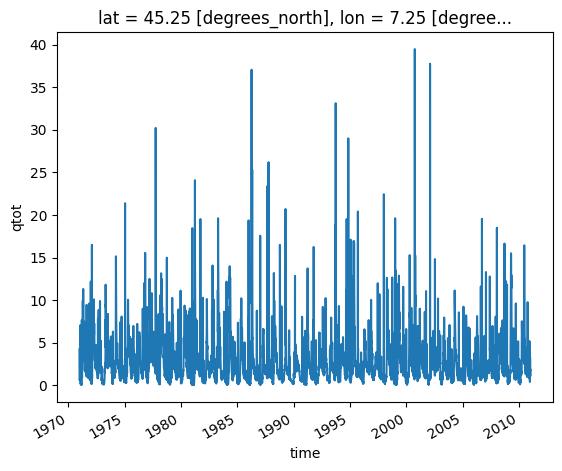

In [5]:
torino = qtot.sel(lat= 45, lon= 7, method = 'nearest')
torino.plot()

This is the full runoff timeseries for the pixel that includes Turin

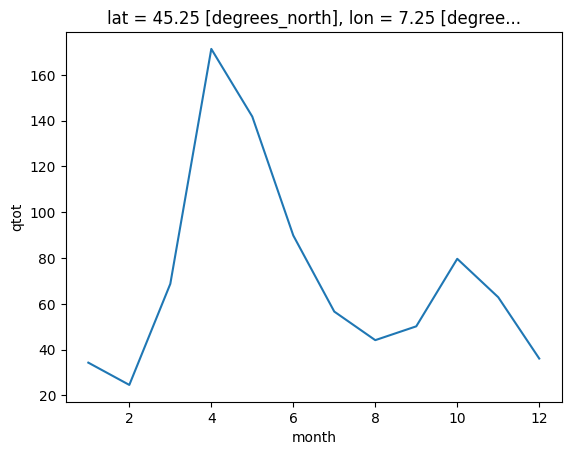

In [6]:
torino_monthly= torino.resample(time = '1M').sum()
torino_mean_monthly = torino_monthly.groupby('time.month').mean()
torino_mean_monthly.plot()

The graph above represent the typical hydrological year ( mean of the 1971-2010 period) for Turin  in mm/month. 

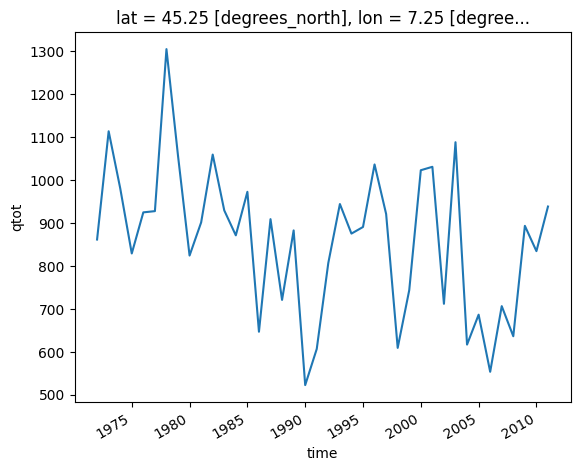

In [7]:
torino_yearlyavg = torino.resample(time= '1Y').sum()

torino_yearlyavg.plot()

Mean yearly values.

Start working on spatial distributions instead of time distributions. The objectives are the one from the article: https://hess.copernicus.org/articles/17/2263/2013/hess-17-2263-2013.pdf. 

The first signature is the mean annual specific runoff:

In [8]:
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import cartopy.feature as cfeature

Q_mean = qtot.mean(dim='time')*365
Q_mean.attrs['units'] = 'mm/year'



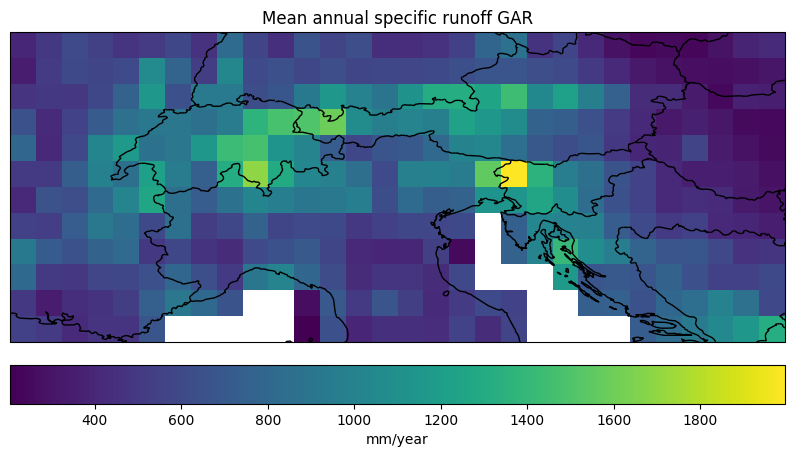

In [9]:



masked_data = np.ma.masked_invalid(Q_mean)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(Q_mean.lon, Q_mean.lat, masked_data, cmap=cmap, transform=ccrs.PlateCarree())
ax.set_title('Mean annual specific runoff GAR')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('mm/year')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()


COMMENTO: 
-sembra ci sia qualcosa di strano nel fatto che ci sono pixel totalmente in mare, possibile sistema di riferimento diverso?

- Può essere in caso sbagliata la proiezione?


Step 2: pardè Coefficient= mean monthly runoff(i= 1:12) / mean annual runoff
 Parde range = Max(Pardè) - Min(Pardè)
 
 


In [10]:
qmonthly= qtot.groupby('time.month').sum(dim='time')
qyearly= qtot.sum(dim='time')


Parde= qmonthly/qyearly
Parde_max= Parde.max(dim='month')
Parde_min= Parde.min(dim='month')

Range= Parde_max- Parde_min

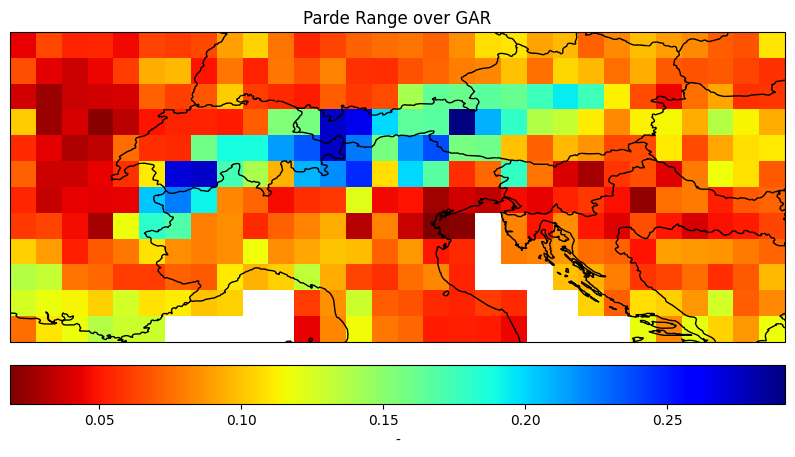

In [11]:
masked_Range = np.ma.masked_invalid(Range)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('jet')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Range, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Range, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Parde Range over GAR')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

Experiment with colormaps,viridis and jet.

3rd Step: Slope of the flow duration curves

mfdc= (Q30%- Q70%)/ 40* Qd

Where Q30 is the value that is exceeded 110 days/ year
Q70 is the value that is exceeded 255 days/ year
Qd is the mean daily value. 

-First, for each pixel i create a mean year by using the function groupby, "dayofyear"
-Secondly i use a for cycle to order the array in each pixel in descending order


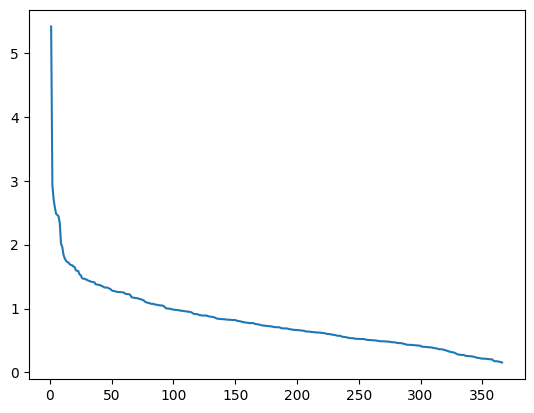

In [12]:
t=np.arange(1,367) 
qtot_day= qtot.groupby("time.dayofyear").mean()
qtot_day_sorted= np.empty((366,12,30))
for i in range(0,12):
    for j in range(0,30):
        dummy= np.sort(qtot_day[:,i,j])[::-1]
        qtot_day_sorted[:,i,j]= dummy 
    
Qd= qtot.mean(dim='time')
Q30 = qtot_day_sorted[111,:,:]
Q70 = qtot_day_sorted[256,:,:]

mfdc= (Q30-Q70)/(40*Qd)

plt.plot(t,qtot_day_sorted[:,6,29])
plt.show()

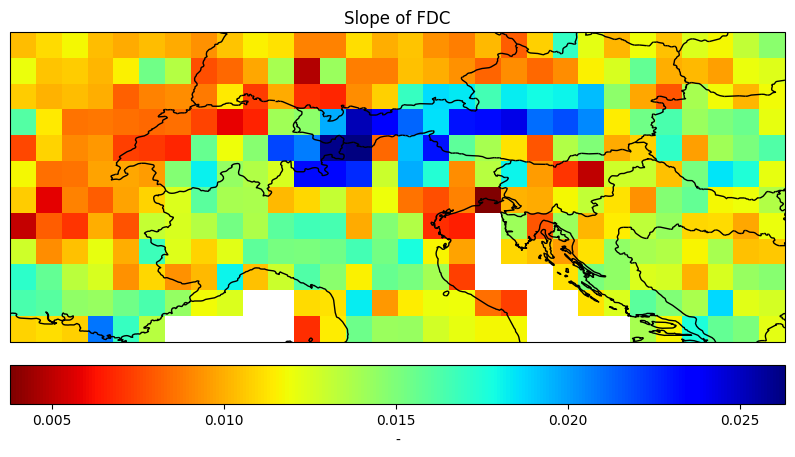

In [13]:
masked_mfdc = np.ma.masked_invalid(mfdc)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('jet')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_mfdc, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_mfdc, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Slope of FDC')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

In [14]:


t=np.arange(1,367) 


4th signature: Normalized low Flows: Qlow = Q95 / Qd


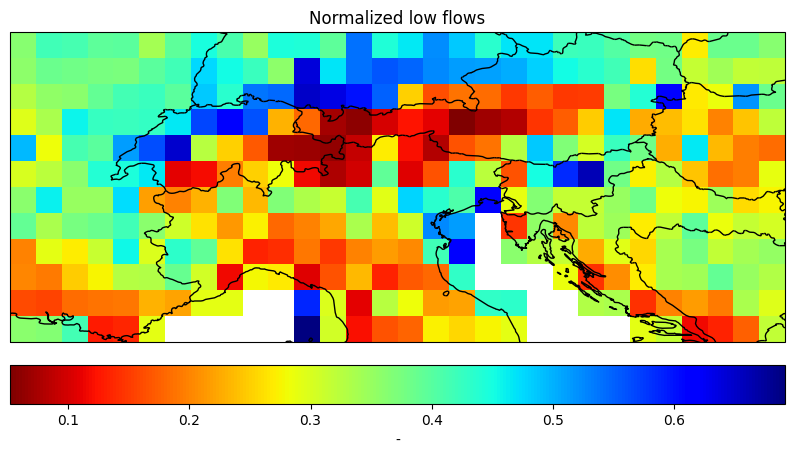

In [15]:
Q95 = qtot_day_sorted[347,:,:]

Qlow = Q95/ Qd


masked_Qlow = np.ma.masked_invalid(Qlow)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('jet')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Normalized low flows')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

5th signature: Normalized low Flows: Qlow = Q5 / Qd



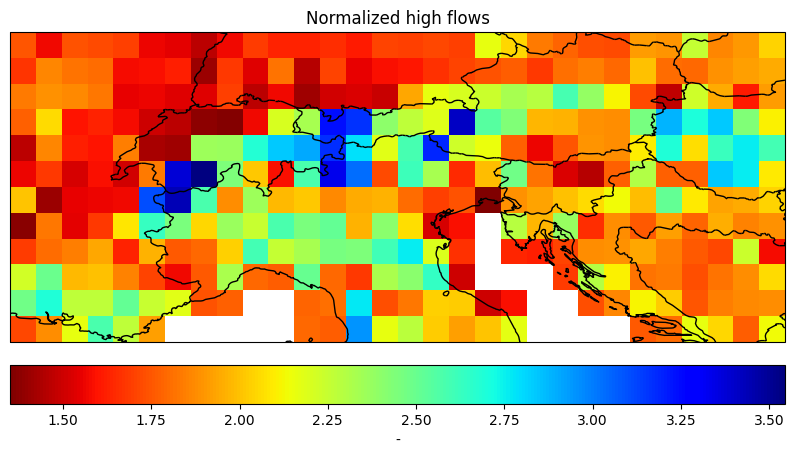

In [16]:
Q5 = qtot_day_sorted[18,:,:]

Qhigh = Q5/ Qd


masked_Qhigh = np.ma.masked_invalid(Qhigh)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('jet')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qhigh, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qhigh, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Normalized high flows')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

6th signature: Integral time scale

Time (days) after which the autocorrelation function values goes below 0.368. "It is a raw measure of the hydrograph's memory".

I use the correlation function: numpy.correlate() to calculate the autocorrelation function for each pixel of the grid.


In [17]:
variance = np.empty((1,12,30))
for i in range(0,12):
    for j in range(0,30):
        dummy= np.var(qtot_day[:,i,j])
        variance[:,i,j]= dummy 
        

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: 

array([[[ 0.22725642,  0.24318946,  0.4746364 ,  0.37910694,
          0.26459785,  0.28432064,  0.32197622,  0.15530543,
          0.67375966,  0.41758288,  0.19619801,  0.40864703,
          0.33180407,  0.34675975,  0.20698052,  0.21423402,
          0.22176092,  0.31043918,  1.05503986,  1.10962458,
          0.27779844,  0.52422921,  0.21270481,  0.11857662,
          0.09664873,  0.10880264,  0.18608093,  0.13678209,
          0.25202931,  0.37011522],
        [ 0.1528196 ,  0.36418068,  0.48102148,  0.41653295,
          0.41358199,  1.37112179,  0.71003124,  0.16607444,
          0.9597366 ,  0.32296825,  0.63511375,  0.14743078,
          0.48530819,  0.25056001,  0.26475385,  0.29242155,
          0.35049949,  0.3927923 ,  0.40275864,  0.50510411,
          0.35091902,  0.47692739,  0.35206108,  0.22290684,
          0.22894022,  0.12856473,  0.12638791,  0.1201413 ,
          0.1466593 ,  0.17432443],
        [ 0.36760062,  0.40586298,  0.39103978,  0.45142258,
          0.5

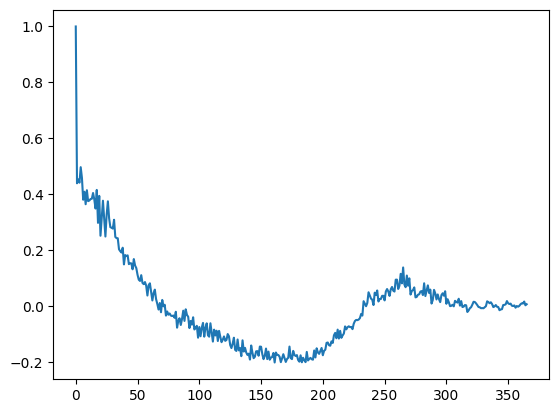

In [18]:
q_normalized= qtot_day-Qd

q_normalized

acorr = np.empty((len(qtot_day),12,30))

for i in range(0,12):
    for j in range(0,30):
        dummy= np.correlate(q_normalized[:,i,j], q_normalized[:,i,j], 'full')[len(qtot_day)-1:] 
        acorr[:,i,j]= dummy/ variance[:,i,j]/len(qtot_day)
        

tc= np.arange(0,len(qtot_day))
plt.plot(tc,acorr[:,11,1])
plt.show()


In [38]:


autocorr = np.array(acorr)
maxi = np.empty((1,12,30))

for i in range(0,12):
    for j in range(0,30):
            dummyy = np.where(autocorr[:,i,j] > 0.386)[0]
            if np.isnan(autocorr[:,i,j]).any() == 1:
                maxi[:,i,j]= np.nan
            elif np.isnan(autocorr[:,i,j]).any() == 0:
                maxi[0,i,j]= dummyy[-1]

  
         


nan

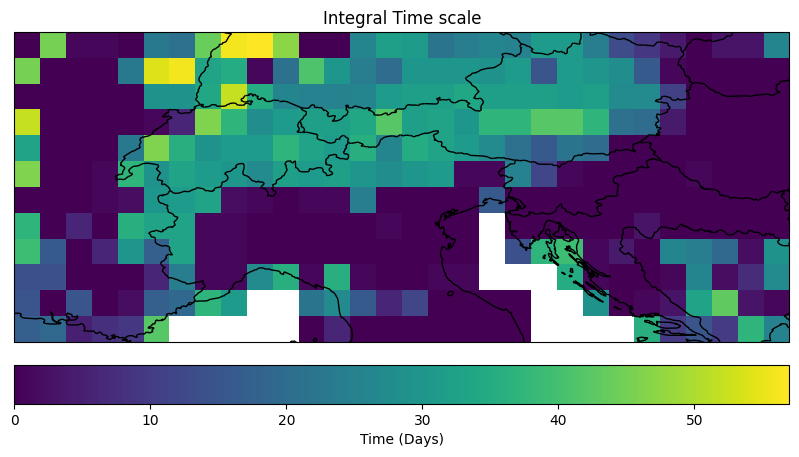

In [42]:
masked_maxi = np.ma.masked_invalid(maxi)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(lon, lat, masked_maxi[0,:,:], cmap=cmap, transform=ccrs.PlateCarree())
ax.set_title('Integral Time scale')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('Time (Days)')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()